# Commodity Food Pricing: Model Experiments

**By:** `MSOE AI-Club "Nourish" Student Research Team`<br/>

**Notebook Purpose:** To explore the use of machine learning to predict the price of commodities in the food industry. By utilizing the clean datasets loaded from `data_analysis.ipynb` into the directory `model_data`, we can begin to explore the use of machine learning to predict the price of commodities in the food industry. This notebook will be divided into sections of varying complexity, each of which will explore a different model type and its performance on the data. The models will be evaluated based on their ability to predict the price of a commodity in the future, given a set of features. The features will be selected based on their correlation to the price of the commodity, as determined in `data_analysis.ipynb`. There is also significant documentation with each section for both code/purpose sanity, sake of future reproducibility, and to help other members of the `MSOE AI-Club "Nourish" Student Research Team` understand the code and its purpose.
* **Part 1 -- Loading the Experiment(s) Data:** Retrieve the data from `model_data` which was cleaned in `data_analysis.ipynb` and prepare it for final use in the model, such as adding the previous amount of trend data based on `N_TREND_SAMPLES`
* **Part 2 -- Building Complex ML Models:** Outline the specific layers and architecture of the model. We are currentlying using the `tensorflow` package avaialble for Python, but we plan to transition to `PyTorch` for extensive testing for DTQL and other reinforcement learning model frameworks.
* **Part 3 -- Experiments with Training Methods:** Different training hyperparameters may be utilized throughout the development of the model. This section will showcase how well the model performed on both learning the training set (loss over epoch) and its performance on the validation set (mean absolute error).

**Research Context:** This research is being conducted as part of the MSOE AI-Club's "Nourish" project, which aims to use machine learning to predict future food prices in order to help farmers in developing countries make better decisions about food storage and crop selection, achieved through the accurate warning administration and prediction of food commodity pricing data by country and food market. This project is pending as part of a relationship with the United Nation's Food and Agriculture Organization (FAO). [FAO Official Statement on the Importance of Research Like This](https://youtu.be/sZx3hhnEHiI)

In [1]:
# External Data Manipulation Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Machine Learning Packages
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

# Internal Python Packages
import os

## Part 1: Loading the Experiment(s) Data
Based on the data retrieved from `data_analysis.ipynb`, get that data into a format capable of being used by a Machine Learning model.

<span style="color: orange;">**Future Experiment:** Generating multiple months or simply estimating a year in advance.</span>

In [2]:
MODEL_DATA_DIRECTORY = 'model_data/wheat_model_data/'
N_TREND_SAMPLES = 3 # Number of price samples for "history" trend (training data)
N_MONTHS_AHEAD = 1 # Number of months ahead to predict
TEST_SIZE = 0.2
OUTPUT_COLUMN_NAME = 'Price'

# Get the number of features for this model (given the model_data chosen)
sample_file_path = os.path.join(MODEL_DATA_DIRECTORY, os.listdir(MODEL_DATA_DIRECTORY)[0])
sample_columns = pd.read_csv(sample_file_path).columns[1:] # Skip 'Unnamed: 0' column
num_input_samples = len(sample_columns[2:-1]) + ((len(sample_columns)-1)*N_TREND_SAMPLES) + 1
print("Num Features: ", num_input_samples)

Num Features:  27


In [3]:
# def grab_n_previous_prices(model_data, n):
#     """
#     For the given model_data, grab the n previous prices and store as a list
#     in a new column called 'n_previous_prices' for each row's associated 'Date'.
#     The current date's price should not be included in the list of previous prices.
#     :param pd.DataFrame model_data: data (model_data to grab from)
#     :param int n: Number of previous prices to grab
#     """
#     # Create a new column to store the n_previous_prices
#     model_data['n_previous_prices'] = None

#     # Iterate through each row
#     for index, row in model_data.iterrows():
#         # Grab the date and price for the current row
#         date = row['Date']
#         price = row['Price']

#         # Grab the n previous prices
#         n_previous_prices = model_data.loc[model_data['Date'] < date]['Price'].tail(n).tolist()

#         # Store the n_previous_prices in the new column
#         model_data.at[index, 'n_previous_prices'] = n_previous_prices

#     return model_data

def grab_n_previous_rows(model_data, n):
    """
    Do the same functionality as the grab_n_previous_prices function, but instead
    of grabbing the previous prices, grab the previous n rows of data.
    Then, those previous rows will be used as the input features for the model.
    :param pd.DataFrame model_data: data (model_data to grab from)
    :param int n: Number of previous rows to grab, target is the current row's price,
                and the previous rows should also include their price. Not n_previous_prices.

    :return pd.DataFrame final_df: The final dataframe with the n_previous_rows as new columns
    """
    final_df = {}

    # Iterate through each row (all rows already sorted by date)
    for index, row in model_data.iterrows():
        # Add the current row to the final_df
        final_df[index] = model_data.loc[index].to_dict()

        # Grab the n previous rows before this row
        n_previous_rows = model_data.loc[:index].tail(n)
        if n_previous_rows.shape[0] < n:
            continue

        n_previous_rows.drop('Unnamed: 0', axis=1, inplace=True) # Drop the index column (not important for model output)
        n_previous_rows.drop('Date', axis=1, inplace=True) # Drop date (unimportant to model output)

        # Store the features of the previous rows as new columns (like price_1, price_2, etc.)
        for i,previous_row in enumerate(n_previous_rows.iterrows()):
             for feature_name in n_previous_rows.columns:
                new_column_name = feature_name + '_' + str(i+1)
                final_df[index][new_column_name] = previous_row[1][feature_name]

    # Create the final dataframe
    final_df = pd.DataFrame(final_df).T

    return final_df


In [4]:
def months_ahead_output(model_data, months_ahead):
    """
    For the given model_data, shift the 'Price' column such that it's some number `months_ahead`
    ahead of the current date so the model using this data can predict the prcie that many
    months ahead.
    :param pd.DataFrame model_data: data (model_data to grab from)
    :param int months_ahead: Number of months ahead to shift the 'Price' column
    """
    # Shift the 'Price' column by `months_ahead` months
    model_data[OUTPUT_COLUMN_NAME] = model_data[OUTPUT_COLUMN_NAME].shift(-months_ahead)

    return model_data

In [5]:
def divide_inputs_and_outputs(row):
    """
    Create a column to specifically be input into an ML model and a column for output
    :param pd.DataFrame row: row to divide

    :return: row with input and output columns
    """
    output = row[OUTPUT_COLUMN_NAME]
    
    # Every other row except for the OUTPUT_COLUMN_NAME
    inputs = row.drop(OUTPUT_COLUMN_NAME).values

    return pd.Series([inputs, output], index=['inputs', 'output'])

In [6]:
def format_for_ML_usage(inputs, outputs):
    """
    Given the inputs and outputs for the model, format the data to be used for ML.
    This is accomplished by splitting the data into training/test tensors
    :param inputs: inputs for the model (list of lists)
    :param output: output for the model (list of values)

    :return: The tensors responsible for testing/training the model and the scaler used to scale the data
            (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)
    """
    # Ensure all data is of numerical type (these are not dataframes)
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    
    # Assume inputs and outputs are already defined and converted to numpy arrays
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False)
    x_train = x_train.astype(float)
    x_test = x_test.astype(float)
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    print(f"x_train shape: {x_train.shape}")
    print(f"x_train dtype: {x_train.dtype}")
    print(f"Sample element from x_train: {x_train[0]}")

    # Check for NaN values
    for i in range(len(x_train)):
        if np.isnan(x_train[i]).any():
            print(f'x_train[{i}] contains NaN values.')


    # Convert them all to numpy arrays
    x_train = np.array(x_train).reshape(-1, num_input_samples)
    x_test = np.array(x_test).reshape(-1, num_input_samples)
    y_train = np.array(y_train).reshape(-1, 1) # required reshape for StandardScaler
    y_test = np.array(y_test).reshape(-1, 1) # required reshape for StandardScaler

    # Standardize/Normalize the dataset
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train).reshape(-1, num_input_samples, 1)
    x_test_scaled = scaler.transform(x_test).reshape(-1, num_input_samples, 1)
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    # Convert to tensors for model ingestion (true training data)
    x_train_tensor = tf.convert_to_tensor(x_train_scaled)
    x_test_tensor = tf.convert_to_tensor(x_test_scaled)
    y_train_tensor = tf.convert_to_tensor(y_train_scaled)
    y_test_tensor = tf.convert_to_tensor(y_test_scaled)

    return (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)

In [7]:
def get_model_data_from_directory():
    """
    Based off the directory provided in the constant MODEL_DATA_DIRECTORY, grab the model_data

    :return: A finalized csv of the model data ready for numpy/tensor conversion
    """
    # Grab all the files in the directory
    model_data = pd.DataFrame()
    for file in os.listdir(MODEL_DATA_DIRECTORY):
        data_to_concat = pd.read_csv(os.path.join(MODEL_DATA_DIRECTORY, file))
        
        # Sort model data where the earliest date comes first and the latest data comes last
        data_to_concat['Date'] = pd.to_datetime(data_to_concat['Date'])
        data_to_concat = data_to_concat.sort_values(by='Date')

        # The 'Sentiment' column contains some nan values when articles weren't published. Replace these with 0
        data_to_concat['Sentiment'] = data_to_concat['Sentiment'].fillna(0)
       
        # Get the n previous prices
        data_to_concat = grab_n_previous_rows(data_to_concat, N_TREND_SAMPLES)
        
        # Concat all the data together
        model_data = pd.concat([model_data, data_to_concat], ignore_index=True).drop(columns=['Unnamed: 0'])

    return model_data

In [8]:
model_data = get_model_data_from_directory()
model_data.drop('Date', axis=1, inplace=True) # Drop date (unimportant to model output)

# Drop any row where NaN is present
model_data = model_data.dropna()

model_data

,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,Price_1,Proteus2_1,Food Price Index_1,...,Wheat Futures_2,Harvest_2,Sentiment_2,Price_3,Proteus2_3,Food Price Index_3,Cereals Price Index_3,Wheat Futures_3,Harvest_3,Sentiment_3
2,0.318897,0.314423,0.399018,0.374836,0.352477,0.390485,1.0,0.307031,0.830354,0.496995,...,0.405733,0.730918,1.0,0.318897,0.314423,0.399018,0.374836,0.352477,0.390485,1.0
3,0.353945,0.368133,0.405947,0.37002,0.357385,0.383057,1.0,0.285422,0.883785,0.47378,...,0.352477,0.390485,1.0,0.353945,0.368133,0.405947,0.37002,0.357385,0.383057,1.0
4,0.36864,0.416001,0.374578,0.347719,0.327074,0.376625,1.0,0.318897,0.314423,0.399018,...,0.357385,0.383057,1.0,0.36864,0.416001,0.374578,0.347719,0.327074,0.376625,1.0
5,0.343996,0.46829,0.366889,0.343675,0.306746,0.369808,1.0,0.353945,0.368133,0.405947,...,0.327074,0.376625,1.0,0.343996,0.46829,0.366889,0.343675,0.306746,0.369808,1.0
6,0.401215,0.518191,0.377723,0.36643,0.333327,0.363512,1.0,0.36864,0.416001,0.374578,...,0.306746,0.369808,1.0,0.401215,0.518191,0.377723,0.36643,0.333327,0.363512,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0.3482,0.678242,0.588079,0.458857,0.333606,0.756849,1.0,0.345688,0.720402,0.519998,...,0.322622,0.757602,1.0,0.3482,0.678242,0.588079,0.458857,0.333606,0.756849,1.0
901,0.36453,0.656036,0.623093,0.439521,0.360232,0.756083,1.0,0.331124,0.69992,0.518688,...,0.333606,0.756849,1.0,0.36453,0.656036,0.623093,0.439521,0.360232,0.756083,1.0
902,0.393514,0.634037,0.639507,0.463615,0.388047,0.755328,1.0,0.3482,0.678242,0.588079,...,0.360232,0.756083,1.0,0.393514,0.634037,0.639507,0.463615,0.388047,0.755328,1.0
903,0.404325,0.610774,0.654949,0.473455,0.401033,0.754534,1.0,0.36453,0.656036,0.623093,...,0.388047,0.755328,1.0,0.404325,0.610774,0.654949,0.473455,0.401033,0.754534,1.0


In [9]:
inputs_and_outputs = model_data.apply(divide_inputs_and_outputs, axis=1)
inputs = inputs_and_outputs['inputs'].tolist(); outputs = inputs_and_outputs['output'].tolist()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False) # Don't shuffle, should be cohesive samples not seen
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler = format_for_ML_usage(inputs, outputs)

print('x_train_tensor shape:', x_train_tensor.shape)
print('x_test_tensor shape:', x_test_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)
print('y_test_tensor shape:', y_test_tensor.shape)

x_train shape: (714, 27)
x_train dtype: float64
Sample element from x_train: [0.31442315 0.3990182  0.37483584 0.35247681 0.39048457 1.
 0.30703063 0.83035384 0.49699536 0.50070803 0.46031802 0.73873865
 1.         0.28542201 0.88378536 0.47377977 0.44960816 0.40573297
 0.73091797 1.         0.31889651 0.31442315 0.3990182  0.37483584
 0.35247681 0.39048457 1.        ]
x_train_tensor shape: (714, 27, 1)
x_test_tensor shape: (179, 27, 1)
y_train_tensor shape: (714, 1)
y_test_tensor shape: (179, 1)


## Part 2: Building Complex ML Models

In [11]:
# Define positional encoding function (another portion for data preprocessing)
def positional_encoding(length, depth):
    """ 
    Create positional encoding
    args:
        length: length of the sequence
        depth: depth of the model
    """
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / depth) for j in range(depth)]
        for pos in range(length)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return tf.cast(pos_enc, dtype=tf.float32)

In [12]:
# Model Architecture
HEAD_SIZE = 64
NUM_HEADS = 16
FF_DIM = 64
NUM_TRANSFORMERS = 20

# ML Optimizer
LEARNING_RATE = 1e-5
CLIP_VALUE = 0.5 # Gradient Clipping (https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)
DROP_OUT_RATE = 0.2 # Tyge's research (look at experiment result)
L1 = 0.000 # L1 Regularization Value
L2 = 0.003 # L2 Regularization Value
d_model = x_train_tensor.shape[-1] 
length = x_train_tensor.shape[1]  

In [13]:
def transformer(head_size, num_heads, ff_dim, dropout=0, num_transformers=NUM_TRANSFORMERS):
    """
    Building a simple transformer based off the original work compiled in
    the research paper "Attention Is All You Need" (https://arxiv.org/pdf/1706.03762.pdf)
    :param int head_size: Size of the attention heads
    :param int num_heads: Number of heads
    :param int ff_dim: Feed forward dimension
    :param float dropout: Dropout rate
    """
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=(num_input_samples, d_model)) # (None, 9, 1)

    # Add positional encoding to the input
    # The positional encoding is added to the input in order to give the model some information about the relative position of the words in the sequence
    # Not including the positional encoding is basically the same as randomizing the order of the data
    positional_inputs = inputs + positional_encoding(num_input_samples, d_model) # (None, 9, 1)
    
    # Multi-Head Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(positional_inputs) # (None, 9, 1)
     
    for i in range(num_transformers):
        # print("At start of transformer ", i, " x shape: ", x.shape)
        x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x) # (None, 9, 1)
        x = tf.keras.layers.Dropout(dropout)(x) # (None, 9, 1)
        
        # Add & Norm
        res = x + positional_inputs # (None, 9, 1)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res) # (None, 9, 1)
        
        # Feed-Forward Network (Using Dense layers instead of Conv1D layers)
        x = tf.keras.layers.Dense(ff_dim, activation='relu', kernel_regularizer=regularizers.L1L2(L1, L2))(x) # (None, 9, 16)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x) # (None, 9, 16)

        # Get the shape of x back to (None, 9, 1)
        x = tf.keras.layers.Dense(d_model)(x)
        
        # Skip Connection     
        x = x + res # (None, 9, 1)
        # print("At end of transformer ", i, " x shape: ", x.shape)

    # Global Average Pooling layer
    # The Global Average Pooling layer reduces the dimensionality/complexity of the data
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # (None, 16)
    
    # Output Layer (WARNING: Don't use sigmoid, requires too high of gradient to achieve ~1 or ~0)
    outputs = tf.keras.layers.Dense(1)(x) # (None, 1)

    return inputs, outputs

In [14]:
inputs,outputs = transformer(HEAD_SIZE, NUM_HEADS, FF_DIM, dropout = DROP_OUT_RATE)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mae')

# Ensure all the weights are reset
tf.keras.backend.clear_session()

# Researching Best Loss Functions for Trendline Prediction
# - Mean Absolute Error (MAE) - Emphasizes that all errors are equally important
# - Mean Absolute Percentage Error (MAPE) - Emphasizes that all errors are equally important (percentage-wise; normalized)


model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 27, 1)]              0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 27, 1)                0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 27, 1)                2         ['tf.__operators__.add[0][0]']
 Normalization)                                                                                   
                                                                                             

In [15]:
# # Example prediction provided by the model (without training)
# example_prediction = model.predict(x_test_tensor)
# example_prediction = scaler.inverse_transform(example_prediction)
# example_prediction = example_prediction.reshape(-1)
# example_prediction

## Part 3: Training the Model
This section is specifically for training the model built in the previous section. Some contants (`NUM_EPOCHS`, `BATCH_SIZE`) are provided and should be the only required parameters to adjust for this section of the experiment. 

A plot of the loss throughout the training process is provided for easy understanding about if the model is overfitting or underfitting. For a review of these concepts, see [this article](https://www.analyticsfordecisions.com/overfitting-and-underfitting/#:~:text=Overfitting%20happens%20when%20the%20model%20is%20too%20complex,poor%20performance%20on%20both%20training%20and%20test%20datasets.).
<br/><br/>
**Potential Future Parameters**
* **Regularization:** L1, L2, Dropout; helps prevent overfitting

In [16]:
def learning_rate_scheduler(epoch, lr):
    """
    Learning rate scheduler
    :param int epoch: current epoch
    :param float lr: current learning rate
    """
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = LearningRateScheduler(learning_rate_scheduler)

In [17]:
NUM_EPOCHS = 20
BATCH_SIZE = 3 # Fiscal Quarters

In [18]:
# Train the model on our training data (train tensors)
history = model.fit(
    x_train_tensor[:-1, :], y_train_tensor[:-1, :],
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [callback]
)

Epoch 1/20

238/238 [==============================] - 64s 87ms/step - loss: 0.8046 - lr: 1.0000e-05
Epoch 2/20
238/238 [==============================] - 23s 97ms/step - loss: 0.7152 - lr: 1.0000e-05
Epoch 3/20
238/238 [==============================] - 24s 100ms/step - loss: 0.6402 - lr: 1.0000e-05
Epoch 4/20
238/238 [==============================] - 23s 97ms/step - loss: 0.6379 - lr: 1.0000e-05
Epoch 5/20
238/238 [==============================] - 24s 102ms/step - loss: 0.6330 - lr: 1.0000e-05
Epoch 6/20
238/238 [==============================] - 26s 111ms/step - loss: 0.6314 - lr: 1.0000e-05
Epoch 7/20
238/238 [==============================] - 27s 115ms/step - loss: 0.6290 - lr: 1.0000e-05
Epoch 8/20
238/238 [==============================] - 30s 125ms/step - loss: 0.6315 - lr: 1.0000e-05
Epoch 9/20
238/238 [==============================] - 33s 140ms/step - loss: 0.6251 - lr: 1.0000e-05
Epoch 10/20
238/238 [==============================] - 32s 136ms/step - loss: 0.6234 - lr: 1.

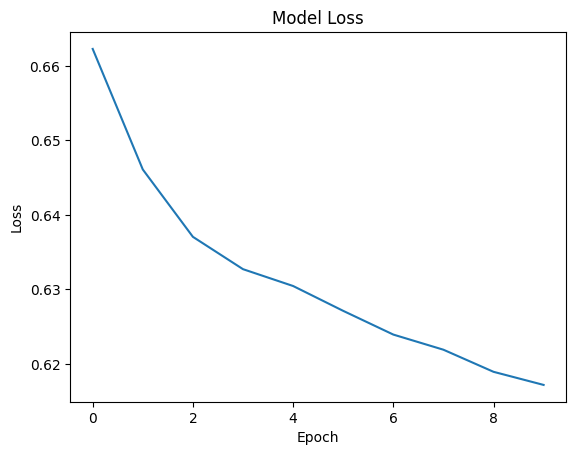

In [ ]:
# Plot the loss over time
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Part 4: Examining Results
In this section, we're plotting the model's predictions versus the actual price point for the commodity in question. However, one plot focuses specifically on the testing data only (this is a better plot to see how well the model is performing/generalizing) and the other focuses on the entire dataset (this is a better plot to see if the model is correlating to the provided dataset at all).

Therefore, when **evaluating the performance** of the model, **the first plot should be used.** 

6/6 [==============================] - 4s 156ms/step


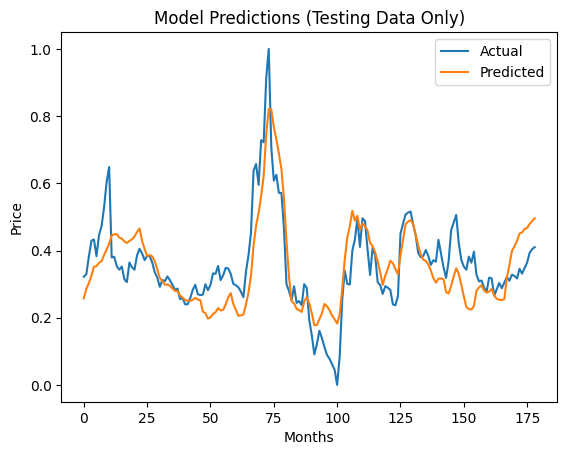

Mean Absolute Error (FINAL ACCURACY METRIC): 0.07115289609686652


In [ ]:
# Plot the model's predictions of the testing data vs the actual data
predictions = model.predict(x_test_tensor)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.reshape(-1)

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions (Testing Data Only)')
plt.ylabel('Price')
plt.xlabel('Months')
plt.legend()
plt.show()

# We use Mean Absolute Error (MAE) as the final accuracy metric because it is the true error (difference) between the actual and predicted values
final_mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error (FINAL ACCURACY METRIC):', final_mae)

23/23 [==============================] - 4s 162ms/step


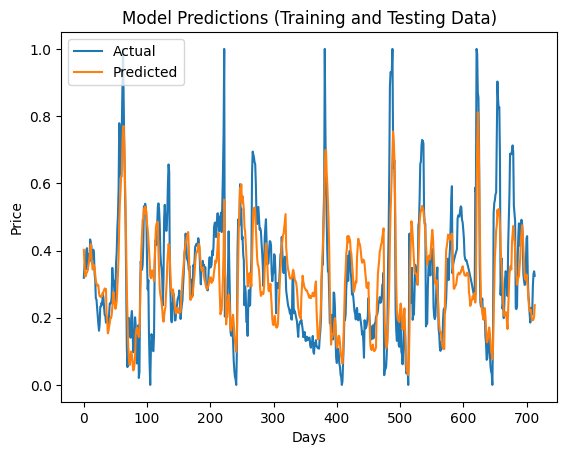

In [ ]:
# Plot the model's predictions (both training and testing) vs the actual data
predictions = model.predict(x_train_tensor)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.reshape(-1)

plt.plot(y_train, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions (Training and Testing Data)')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()

In [ ]:
# Save the model to saved_models
model.save(f'saved_models/wheat_price_transformer_model_{final_mae}.h5')

c:\Users\paulsonb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
